<a href="https://colab.research.google.com/github/vijayakuruba/IFT6759_Distribution_shifts_WILDS/blob/main/Data_augument.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [12]:
from PIL import Image
from matplotlib import pyplot as plt

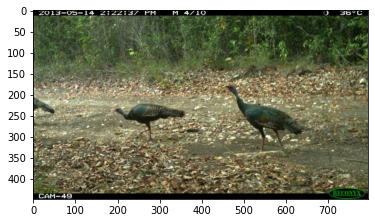

In [23]:
x =Image.open("/content/drive/MyDrive/IFT6135/99599904-21bc-11ea-a13a-137349068a90.jpg")
plt.imshow(x)

In [25]:
x.size

(796, 448)

In [74]:
%cd /content/drive/MyDrive/IFT6759_Distribution_shifts_WILDS/examples
!ls


/content/drive/MyDrive/IFT6759_Distribution_shifts_WILDS/examples
algorithms  data_augmentation  logs	  optimizer.py	scheduler.py   utils.py
configs     evaluate.py        losses.py  __pycache__	train.py
data	    __init__.py        models	  run_expt.py	transforms.py


In [5]:
import copy
from typing import List

import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from data_augmentation.randaugment import FIX_MATCH_AUGMENTATION_POOL, RandAugment

In [ ]:
target_resolution=(224,224)
_DEFAULT_IMAGE_TENSOR_NORMALIZATION_MEAN = [0.485, 0.456, 0.406]
_DEFAULT_IMAGE_TENSOR_NORMALIZATION_STD = [0.229, 0.224, 0.225]

normalization = transforms.Normalize(
        _DEFAULT_IMAGE_TENSOR_NORMALIZATION_MEAN,
        _DEFAULT_IMAGE_TENSOR_NORMALIZATION_STD,
    )

In [49]:
should_normalize = True # True/False
strong_transform=([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(
                size=target_resolution
            ),
            RandAugment(
                n=2,
                augmentation_pool=FIX_MATCH_AUGMENTATION_POOL,
            ),
        ])

if should_normalize:
   strong_transform.append(transforms.ToTensor())
   strong_transform.append(normalization)
strong_transform=transforms.Compose(strong_transform)


#Randaugument 

Without normalisation

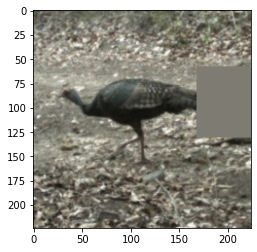

In [46]:
img = strong_transform(x)
#img=img.squeeze().permute(1,2,0)
plt.imshow(img)

with Normalisation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


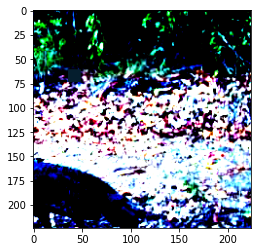

In [51]:
img = strong_transform(x)
img=img.squeeze().permute(1,2,0)
plt.imshow(img)

#Weak Augument

In [55]:
should_normalize = True #True/False
weak_transform = (
        [
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(
                size=target_resolution,
          ),
        ]
    )
if should_normalize:
   weak_transform.append(transforms.ToTensor())
   weak_transform.append(normalization)
weak_transform = transforms.Compose(weak_transform)

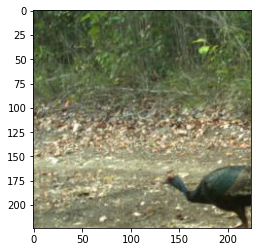

In [54]:
img1 = weak_transform(x)
#img=img.squeeze().permute(1,2,0)
plt.imshow(img1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


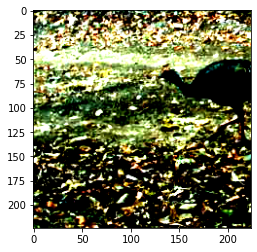

In [58]:
img1 = weak_transform(x)
img1=img1.squeeze().permute(1,2,0)
plt.imshow(img1)

In [91]:
%cd /content/drive/MyDrive/IFT6759_Distribution_shifts_WILDS/examples
!ls

/content/drive/MyDrive/IFT6759_Distribution_shifts_WILDS/examples
algorithms  data_augmentation  logs	  optimizer.py	scheduler.py   utils.py
configs     evaluate.py        losses.py  __pycache__	train.py
data	    __init__.py        models	  run_expt.py	transforms.py


#Cutout Augument

In [111]:
from data_augmentation.cutout_augment.cutoutaugment import CutoutAugment
#from data_augmentation.randaugment import FIX_MATCH_AUGMENTATION_POOL, RandAugment


In [117]:
should_normalize = False # True/False
cutout_transform=([
          transforms.RandomCrop(size=target_resolution),
            CutoutAugment(),
        ])

if should_normalize:
   cutout_transform.append(transforms.ToTensor())
   cutout_transform.append(normalization)
cutout_transform=transforms.Compose(cutout_transform)

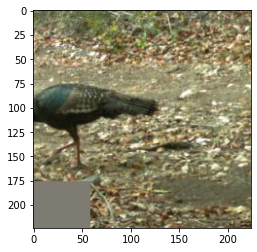

In [118]:
img2 = cutout_transform(x)
#img2=img2.squeeze().permute(1,2,0)
plt.imshow(img2)